# Imports

In [1]:
import pandas as pd
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob

import numpy as np
import pandas as pd
#import polars as pl
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
#import xgboost as xgb
#from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
import optuna as optuna
from optuna.samplers import TPESampler, NSGAIISampler, CmaEsSampler, GridSampler




## Import data

In [2]:
df = pd.read_csv(r"C:\Users\maorb\CSVs\MetaculusNewest18_6.csv")
df_new = pd.read_csv(r"C:\Users\maorb\CSVs\MetaculusNewest17_6.csv")

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9443 entries, 0 to 9442
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     9443 non-null   int64  
 1   title                  9443 non-null   object 
 2   predictions_num        9443 non-null   int64  
 3   Unique_predictors      9443 non-null   int64  
 4   Response_date          9443 non-null   object 
 5   publish_time           9443 non-null   object 
 6   resolved_time          9443 non-null   object 
 7   number_of_forecasters  9443 non-null   int64  
 8   prediction_count       9443 non-null   int64  
 9   q1                     9443 non-null   float64
 10  q2                     9443 non-null   float64
 11  q3                     9443 non-null   float64
 12  avg                    9443 non-null   float64
 13  w_avg                  9443 non-null   float64
 14  var                    9443 non-null   float64
 15  Resu

In [344]:
df['id'].unique()

array([3444, 3446, 3451, 3462, 3481, 3482, 3483, 3485, 3486, 3487, 3488,
       3489, 3490, 3492, 3493, 3495, 3496, 3497, 3499, 3504, 3501, 3503,
       3513, 3578, 3590, 3595, 3607, 3611, 3630, 3633, 3632, 3655, 3666,
       3612, 3671, 3677, 3688, 3699, 3614, 3656, 3681, 3710, 3724, 3734,
       3744, 3737, 3745, 3776, 3697, 3762, 3779, 3790, 3791, 3825, 3859,
       3843, 3855, 3794, 3875, 3863, 3895, 3897, 3894, 3912, 3918, 3921,
       3932, 3896, 3900, 3856, 4906, 3991, 4013, 4040, 4035, 4075, 4097,
       4098, 4206, 4220, 4260, 4238, 4272, 4253, 4277, 4279, 4280, 4281,
       4313, 4318,  804, 4207, 4354, 4415, 4414, 4403, 4425], dtype=int64)

In [3]:
df1 = df.copy() #df without title
df1.drop(columns = 'title',inplace = True)
df_new1 = df_new.copy()
df_new1.drop(columns = 'title',inplace = True)

In [4]:
# DAYOFWEEK, HOUR, WEEKLY Cyclical FEATURES

# PUBLISH TIME
df1['publish_time'] = pd.to_datetime(df1['publish_time'])

# RESPONSE DATE
df1['Response_date'] = df1['Response_date']
df1['Response_date'] = pd.to_datetime(df1['Response_date'], errors='coerce')
df1['Response_date_dayofweek'] = df1['Response_date'].dt.dayofweek
df1['Response_date_hour'] = df1['Response_date'].dt.hour
df1['Response_date_month'] = df1['Response_date'].dt.month
df1['Response_date_day'] = df1['Response_date'].dt.day
df1['Response_date_minute'] = df1['Response_date'].dt.minute    


In [339]:
df1['Response_date_day'].value_counts()

Response_date_day
28    575
27    474
16    393
4     384
18    347
1     334
17    334
3     326
2     307
26    301
19    300
23    299
29    297
15    294
12    283
11    281
5     280
20    280
8     279
7     278
30    276
14    276
21    274
25    270
22    267
24    259
13    250
10    246
9     241
6     239
31    199
Name: count, dtype: int64

In [247]:
#df_new1['publish_time'] = pd.to_datetime(df_new1['publish_time'])


# RESPNSE DATE
df_new1['Response_date'] = pd.to_datetime(df_new1['Response_date'], errors='coerce')
df_new1['Response_date_dayofweek'] = df_new1['Response_date'].dt.dayofweek
df_new1['Response_date_hour'] = df_new1['Response_date'].dt.hour
df_new1['Response_date_month'] = df_new1['Response_date'].dt.month

## Feature engineering

In [392]:
import numpy as np
# For now, We'll create features for hour and dayofweek, more to come!
# For further reading: https://medium.com/@axelazara6/why-we-need-encoding-cyclical-features-79ecc3531232
# https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

#First option

df1['Response_date_Hour_sin'] = np.sin(df1['Response_date_hour'] * np.pi/24)
df1['Response_date_Hour_cos'] = np.cos(df1['Response_date_hour'] * np.pi/24)
df1['Response_date_dayofweek_sin'] = np.sin(df1['Response_date_dayofweek'] * np.pi/7)
df1['Response_date_dayofweek_cos'] = np.cos(df1['Response_date_dayofweek'] * np.pi/7)
df1['Response_date_month_sin'] = np.sin(df1['Response_date_month'] * np.pi/12)
df1['Response_date_month_cos'] = np.cos(df1['Response_date_month'] * np.pi/12)
df1['Response_date_day_sin'] = np.sin(df1['Response_date_day'] * np.pi/31)
df1['Response_date_day_cos'] = np.cos(df1['Response_date_day'] * np.pi/31)
df1['Response_date_minute_sin'] = np.sin(df1['Response_date_minute'] * np.pi/60)
df1['Response_date_minute_cos'] = np.cos(df1['Response_date_minute'] * np.pi/60)

In [5]:
#Second option
df1['Response_date_Hour_sin'] = np.sin(df1['Response_date_hour'] /(2 * 24 * np.pi))
df1['Response_date_Hour_cos'] = np.cos(df1['Response_date_hour'] /(2 * 24 * np.pi))
df1['Response_date_dayofweek_sin'] = np.sin(df1['Response_date_dayofweek'] /(2 * 7 * np.pi))
df1['Response_date_dayofweek_cos'] = np.cos(df1['Response_date_dayofweek'] /(2 * 7 * np.pi))
df1['Response_date_month_sin'] = np.sin(df1['Response_date_month'] /(2 * 12 * np.pi))
df1['Response_date_month_cos'] = np.cos(df1['Response_date_month'] /(2 * 12 * np.pi))
df1['Response_date_day_sin'] = np.sin(df1['Response_date_day'] /(2 * 31 * np.pi))
df1['Response_date_day_cos'] = np.cos(df1['Response_date_day'] /(2 * 31 * np.pi))
df1['Response_date_minute_sin'] = np.sin(df1['Response_date_minute'] /(2 * 60 * np.pi))
df1['Response_date_minute_cos'] = np.cos(df1['Response_date_minute'] /(2 * 60 * np.pi))

In [10]:
mean_hour_sin = df1.groupby('id')['Response_date_Hour_sin'].mean()
mean_hour_cos = df1.groupby('id')['Response_date_Hour_cos'].mean()
mean_dayofweek_sin = df1.groupby('id')['Response_date_dayofweek_sin'].mean()
mean_dayofweek_cos = df1.groupby('id')['Response_date_dayofweek_cos'].mean()
mean_month_sin = df1.groupby('id')['Response_date_month_sin'].mean()
mean_month_cos = df1.groupby('id')['Response_date_month_cos'].mean()
mean_day_sin = df1.groupby('id')['Response_date_day_sin'].mean()
mean_day_cos = df1.groupby('id')['Response_date_day_cos'].mean()
mean_minute_sin = df1.groupby('id')['Response_date_minute_sin'].mean()
mean_minute_cos = df1.groupby('id')['Response_date_minute_cos'].mean()

c:\Users\maorb\anaconda3\envs\Yofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maorb\anaconda3\envs\Yofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


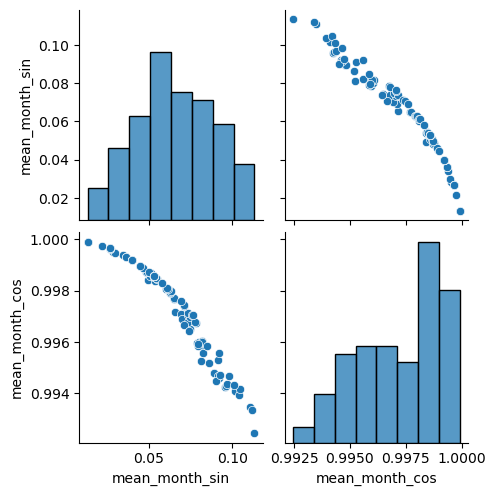

In [342]:
month_df = pd.DataFrame({'mean_month_sin':mean_month_sin, 'mean_month_cos':mean_month_cos})
sns.pairplot(month_df)

In [314]:
#First option

df_new1['Response_date_Hour_sin'] = np.sin(df_new1['Response_date_hour'] * np.pi/24)
df_new1['Response_date_Hour_cos'] = np.cos(df_new1['Response_date_hour'] * np.pi/24)
df_new1['Response_date_dayofweek_sin'] = np.sin(df_new1['Response_date_dayofweek'] * np.pi/3.5)
df_new1['Response_date_dayofweek_cos'] = np.cos(df_new1['Response_date_dayofweek'] * np.pi/3.5)
df_new1['Response_date_month_sin'] = np.sin(df_new1['Response_date_month'] * np.pi/12)
df_new1['Response_date_month_cos'] = np.cos(df_new1['Response_date_month'] * np.pi/12)

In [326]:
#Second option
df_new1['Response_date_Hour_sin'] = np.sin(df_new1['Response_date_hour'] /(2 * 24 * np.pi))
df_new1['Response_date_Hour_cos'] = np.cos(df_new1['Response_date_hour'] /(2 * 24 * np.pi))
df_new1['Response_date_dayofweek_sin'] = np.sin(df_new1['Response_date_dayofweek'] /(2 * 7 * np.pi))
df_new1['Response_date_dayofweek_cos'] = np.cos(df_new1['Response_date_dayofweek'] /(2 * 7 * np.pi))
df_new1['Response_date_month_sin'] = np.sin(df_new1['Response_date_month'] /(2 * 12 * np.pi))
df_new1['Response_date_month_cos'] = np.cos(df_new1['Response_date_month'] /(2 * 12 * np.pi))

In [327]:
mean_hour_sin_new = df_new1.groupby('id')['Response_date_Hour_sin'].mean()
mean_hour_cos_new = df_new1.groupby('id')['Response_date_Hour_cos'].mean()
mean_dayofweek_sin_new = df_new1.groupby('id')['Response_date_dayofweek_sin'].mean()
mean_dayofweek_cos_new = df_new1.groupby('id')['Response_date_dayofweek_cos'].mean()
mean_month_sin_new = df_new1.groupby('id')['Response_date_month_sin'].mean()
mean_month_cos_new = df_new1.groupby('id')['Response_date_month_cos'].mean()

In [11]:
# df1

last_entries_1 = df1.groupby('id').last()
last_q2_1 = last_entries_1['q2']
id_column_1 = df1['id'].unique()


In [328]:
# df_newest

last_entries_new = df_new1.groupby('id').last()
last_q2_new = last_entries_new['q2']
id_column_new = df_new1['id'].unique()

In [241]:
mean_hour_sin

id
804     0.640932
3444    0.592987
3446    0.487909
3451    0.586634
3462    0.636752
          ...   
4403    0.589720
4414    0.660335
4415    0.504807
4425    0.616207
4906    0.575125
Name: Response_date_Hour_sin, Length: 97, dtype: float64

In [12]:
df1_n = pd.DataFrame({'id_column': id_column_1,
                                     'mean_hour_sin': mean_hour_sin,
                                        'mean_hour_cos': mean_hour_cos,
                                        'mean_dayofweek_sin': mean_dayofweek_sin,
                                        'mean_dayofweek_cos': mean_dayofweek_cos,
                                        'mean_month_sin': mean_month_sin,
                                        'mean_month_cos': mean_month_cos,
                                          'mean_day_sin': mean_day_sin,
                                          'mean_day_cos': mean_day_cos,
                                          'mean_minute_sin': mean_minute_sin,
                                          'mean_minute_cos': mean_minute_cos,
                                     'last_q2': last_q2_1}).reset_index(drop=True)

In [21]:
df1_n

,id_column,mean_hour_sin,mean_hour_cos,mean_dayofweek_sin,mean_dayofweek_cos,mean_month_sin,mean_month_cos,mean_day_sin,mean_day_cos,mean_minute_sin,mean_minute_cos,last_q2
0,3444,0.076862,0.996000,0.062483,0.997167,0.079285,0.995897,0.073144,0.996802,0.070509,0.996425,0.39
1,3446,0.084244,0.995277,0.077954,0.995841,0.013263,0.999912,0.072487,0.996270,0.078793,0.995944,0.60
2,3451,0.083627,0.994990,0.067860,0.996626,0.081257,0.995832,0.082321,0.995548,0.071818,0.996304,0.08
3,3462,0.078679,0.995683,0.064946,0.996909,0.086205,0.995193,0.076602,0.996032,0.080564,0.995738,0.01
4,3481,0.086280,0.995229,0.072128,0.996408,0.078764,0.995960,0.078424,0.995903,0.079331,0.995791,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...
92,4354,0.079205,0.995652,0.073023,0.996255,0.076612,0.997042,0.092492,0.994627,0.077815,0.995927,0.01
93,4415,0.083864,0.995502,0.053955,0.997765,0.069278,0.997582,0.106864,0.993334,0.080593,0.995759,0.72
94,4414,0.073821,0.995829,0.067636,0.996649,0.110826,0.993479,0.083630,0.995358,0.083313,0.995540,0.06
95,4403,0.079604,0.995712,0.067189,0.996705,0.112134,0.993371,0.082868,0.995386,0.073600,0.996241,0.04


In [329]:
df_newwest = pd.DataFrame({'id_column': id_column_new,
                                     'mean_hour_sin_new': mean_hour_sin_new,
                                     'mean_hour_cos_new': mean_hour_cos_new,
                                    'mean_dayofweek_sin_new': mean_dayofweek_sin_new,
                                     'mean_dayofweek_cos_new': mean_dayofweek_cos_new,
                                    'mean_month_sin_new': mean_month_sin_new,
                                    'mean_month_cos_new': mean_month_cos_new,
                                     'last_q2': last_q2_new}).reset_index(drop=True)

In [330]:
df_newwest

,id_column,mean_hour_sin_new,mean_hour_cos_new,mean_dayofweek_sin_new,mean_dayofweek_cos_new,mean_month_sin_new,mean_month_cos_new,last_q2
0,14370,0.079652,0.995474,0.069485,0.997307,0.013263,0.999912,0.970
1,14371,0.083500,0.995011,0.066337,0.997465,0.013263,0.999912,0.010
2,14372,0.079914,0.995291,0.068739,0.997187,0.013263,0.999912,0.010
3,14373,0.080535,0.995198,0.066899,0.997292,0.013263,0.999912,0.010
4,14375,0.085367,0.994711,0.064849,0.997522,0.013263,0.999912,0.010
5,14376,0.091065,0.994357,0.067135,0.997369,0.013263,0.999912,0.010
6,14377,0.085785,0.994776,0.067459,0.997366,0.013263,0.999912,0.010
7,14378,0.090562,0.994473,0.064932,0.997500,0.013263,0.999912,0.010
8,14380,0.083372,0.995075,0.067910,0.997381,0.013263,0.999912,0.010
9,14384,0.088074,0.994792,0.069986,0.997312,0.013263,0.999912,0.010


In [14]:
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold,StratifiedKFold
y = df1_n["last_q2"]
df_train= df1_n.drop(columns= ['last_q2','id_column'])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [367]:
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold,StratifiedKFold
y_new = df_newwest["last_q2"]
df_train_new= df_newwest.drop(columns= ['last_q2','id_column'])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
#Copied 100 % from chatgpt with directions


# df_train is the training dataframe and y is the target variable
params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",  # Use a regression metric
    "max_depth": 10,  
    "learning_rate": 0.05,
    #"n_estimators": 2000,  
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "reg_alpha": 0.1,
    "reg_lambda": 10,
    "extra_trees":True,
    'num_leaves':64
}
fam_1 = {'reg_alpha': 0.9489884505706287, 'subsample': 0.7968402595217651, 'scale_pos_weight': 3.0351417793837583, 'reg_lambda': 0.06561699168479634, 'max_depth': 5, 'learning_rate': 0.01024272377141082, 'colsample_bytree': 0.6404564943744389, 'colsample_bynode': 0.6106076880906177}

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import lightgbm as lgb
import numpy as np

# Assuming df_trainis the training dataframe and y_new is the target variable
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fitted_models_lgb = []
cv_scores_lgb = []
iters = []
learning_curves= []
for idx_train, idx_valid in kf.split(df_train):
    X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
    
    # Define LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
    
    # Train LightGBM model
    model = lgb.train(famPArams, train_data, valid_sets=[valid_data],
                      callbacks=[lgb.log_evaluation(200), lgb.early_stopping(1000)])
    # Evaluate model on validation data
    y_pred_valid = model.predict(X_valid)
    rmse_score = root_mean_squared_error(y_valid, y_pred_valid)  # RMSE
    
    # Store model and score
    fitted_models_lgb.append(model)
    cv_scores_lgb.append(rmse_score)
    learning_curves.append(rmse_score)
    iters.append(idx_train)

# Display CV RMSE scores
print("CV RMSE scores: ", cv_scores_lgb)
print("Maximum CV RMSE score: ", max(cv_scores_lgb))

# Display CV RMSE scores
print("CV RMSE scores: ", cv_scores_lgb)
print("Maximum CV RMSE score: ", max(cv_scores_lgb))


Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l2: 0.166511
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.167296
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l2: 0.136911
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's l2: 0.121456
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l2: 0.15042
CV RMSE scores:  [0.4080577787844453, 0.4090178729162723, 0.370015369365201, 0.3485056596426252, 0.3878400860717364]
Maximum CV RMSE score:  0.4090178729162723
CV RMSE scores:  [0.4080577787844453, 0.4090178729162723, 0.370015369365201, 0.3485056596426252, 0.3878400860717364]
Maximum CV RMSE score:  0.40901

In [17]:
import optuna as optuna
from lightgbm import LGBMRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import Dataset
import warnings
from sklearn.metrics import roc_auc_score
from optuna.samplers import TPESampler, NSGAIISampler, CmaEsSampler, GridSampler

random_state =  42
import logging

# Set LightGBM logging level to suppress warnings
logging.getLogger('lightgbm').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")
def objective(trial):
    params = {
            "boosting_type": "gbdt",
            "objective": "regression",
            "metric": "rmse",
            'num_leaves':  64, #trial.suggest_int('num_leaves', 60,66),
            "extra_trees":True,
            "reg_alpha": trial.suggest_float('reg_alpha', 0.05, 1, log = True),
            "n_estimators": 2000,
            "metric": "auc",
            'subsample': trial.suggest_float('subsample', 0.6, 0.95, log = True),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.8, 5, log = True),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.05, 0.3, log = True),
            #'min_child_weight': 1,
            'max_depth': trial.suggest_int('max_depth',3,6),
            #'gamma': trial.suggest_float('gamma', 0.4, 0.88, log = True),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log = True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.55, 0.83, log = True),
            'colsample_bynode': trial.suggest_float('colsample_bynode', 0.55, 0.83, log = True),
            }
    rmse_list = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for idx_train, idx_valid in kf.split(df_train):
        X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]
        X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
        
        # Define LightGBM datasets with free_raw_data=False
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid)
        
        model = lgb.train(params, train_data, valid_sets=[valid_data])
        predictions = model.predict(X_valid)
        rmse = mean_squared_error(y_valid, predictions, squared=False)
        rmse_list.append(rmse)
    
    mean_rmse = np.mean(rmse_list)
    return mean_rmse

# Example usage:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

[I 2024-08-17 12:27:50,650] A new study created in memory with name: no-name-6f7cbf0f-8815-4272-99a0-dfffe9d2e47d
[I 2024-08-17 12:27:52,764] Trial 0 finished with value: 0.40095469628791724 and parameters: {'reg_alpha': 0.41497819209591325, 'subsample': 0.6241824440854697, 'scale_pos_weight': 2.2904184847815294, 'reg_lambda': 0.23231858312815096, 'max_depth': 6, 'learning_rate': 0.010003474112064243, 'colsample_bytree': 0.702786144310612, 'colsample_bynode': 0.5859996243553934}. Best is trial 0 with value: 0.40095469628791724.
[I 2024-08-17 12:27:55,649] Trial 1 finished with value: 0.43016516603121957 and parameters: {'reg_alpha': 0.2102208560815203, 'subsample': 0.9185804679675263, 'scale_pos_weight': 1.0079179024348077, 'reg_lambda': 0.0587538324737727, 'max_depth': 4, 'learning_rate': 0.1588550933040987, 'colsample_bytree': 0.5678390371020745, 'colsample_bynode': 0.7974419607577762}. Best is trial 0 with value: 0.40095469628791724.
[I 2024-08-17 12:27:58,464] Trial 2 finished with

In [18]:
famPArams = study.best_params
print("Best Hyperparameters:", famPArams)

Best Hyperparameters: {'reg_alpha': 0.9620434379754236, 'subsample': 0.6674418493756764, 'scale_pos_weight': 1.5205262265826707, 'reg_lambda': 0.21204715804728014, 'max_depth': 6, 'learning_rate': 0.010077316866957913, 'colsample_bytree': 0.8263905652366199, 'colsample_bynode': 0.5980255540539734}


In [432]:
famPArams

{'num_leaves': 63,
 'reg_alpha': 0.3831919033471625,
 'subsample': 0.6315774695708026,
 'scale_pos_weight': 0.8063294515266103,
 'max_depth': 1,
 'learning_rate': 0.01196534211013587,
 'colsample_bytree': 0.6927906233388017,
 'colsample_bynode': 0.6957333180435282}

In [437]:
#Copied 100 % from chatgpt with directions

# df_train_new is the training dataframe and y_new is the target variable

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",  # Use a regression metric
    "max_depth": 10,  
    "learning_rate": 0.05,
    #"n_estimators": 2000,  
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "reg_alpha": 0.1,
    "reg_lambda": 10,
    "extra_trees":True,
    'num_leaves':64,
    "verbose": -1,
}

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import lightgbm as lgb
import numpy as np

# Assuming df_trainis the training dataframe and y_new is the target variable
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fitted_models_lgb = []
cv_scores_lgb = []
iters = []
learning_curves= []
for idx_train, idx_valid in kf.split(df_train_new):
    X_train, y_train = df_train_new.iloc[idx_train], y_new.iloc[idx_train]
    X_valid, y_valid = df_train_new.iloc[idx_valid], y_new.iloc[idx_valid]
    
    # Define LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
    
    # Train LightGBM model
    model = lgb.train(famPArams, train_data, valid_sets=[valid_data],
                      callbacks=[lgb.log_evaluation(200), lgb.early_stopping(1000)])
    # Evaluate model on validation data
    y_pred_valid = model.predict(X_valid)
    rmse_score = root_mean_squared_error(y_valid, y_pred_valid)  # RMSE
    
    # Store model and score
    fitted_models_lgb.append(model)
    cv_scores_lgb.append(rmse_score)
    learning_curves.append(rmse_score)
    iters.append(idx_train)

# Display CV RMSE scores
print("CV RMSE scores: ", cv_scores_lgb)
print("Maximum CV RMSE score: ", max(cv_scores_lgb))

# Display CV RMSE scores
print("CV RMSE scores: ", cv_scores_lgb)
print("Maximum CV RMSE score: ", max(cv_scores_lgb))


Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l2: 0.163514
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.125212
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[3]	valid_0's l2: 0.101586
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[44]	valid_0's l2: 0.139233
Training until validation scores don't improve for 1000 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0747627
CV RMSE scores:  [0.4043681853971889, 0.3538530712969334, 0.3187259282683228, 0.37313970034040134, 0.27342777548842173]
Maximum CV RMSE score:  0.4043681853971889
CV RMSE scores:  [0.4043681853971889, 0.3538530712969334, 0.3187259282683228, 0.37313970034040134, 0.27342777548842173]
Maximum CV RMSE score

In [111]:
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold,StratifiedKFold
y_new_1 = df1_n["last_q2"]
df_train_n= df1_n.drop(columns= ['last_q2','id_column'])


In [112]:
predictions = np.zeros(df_train_n.shape[0])
best_model_index = np.argmin(cv_scores_lgb)
best_model = fitted_models_lgb[best_model_index]
predictions = best_model.predict(df_train_n)

In [113]:
predictions = best_model.predict(df_train_n)

In [114]:
df1_n['preds'] = predictions

In [115]:
df1_n.head(50)

,id_column,mean_hour_sin_new,mean_hour_cos_new,mean_dayofweek_sin_new,mean_dayofweek_cos_new,last_q2,preds
0,3444,-1.903728e-14,1.0,-0.099010,0.009901,0.390,0.355696
1,3446,-2.208847e-14,1.0,-0.168317,-0.039604,0.600,0.355696
2,3451,-1.829928e-14,1.0,-0.217822,0.049505,0.080,0.355696
3,3462,-1.648995e-14,1.0,-0.207921,-0.079208,0.010,0.355696
4,3481,-2.028830e-14,1.0,-0.049505,-0.079208,0.010,0.355696
5,3482,-2.083715e-14,1.0,-0.168317,-0.059406,0.890,0.355696
6,3483,-1.707240e-14,1.0,0.009901,0.019802,0.990,0.355696
7,3485,-1.767376e-14,1.0,-0.257426,0.089109,0.990,0.355696
8,3486,-2.660547e-14,1.0,0.128713,-0.019802,0.990,0.355696
9,3487,-1.876533e-14,1.0,-0.089109,-0.019802,0.020,0.355696


In [116]:
np.linalg.norm(df1_n['last_q2'] - df1_n['preds'])

3.948037265345817

### Q: HOW CAN WE ELIMINATE ROWS DEPENDENCY?
#### For every question, we'll only keep the variance and features that arew time related, for every question MAYBE only 1 row 

### option1: let's draw infinite number of questions and look only at the last predictions -> not good enough, we want to refer to the timelines in our research
#### We'll start with the mean/median an then we'll see


### Q: HOW CAN WE CREATE BETTER VALIDATION?
#### When we fetch all the questions, we leave create test set of 20/30% of the questions which is untouchable and the rest is training, 20% percent of the training we'll not work with as well

### A:

### HOW MANY QUESTION SHOULD WE FETCH FROM THE API?
#### Let's start with a lot, than narrow it down

### SHOULD WE SET A LOWER LIMIT FOR NUM OF PREDICTORS FOR EACH QUESTION?
#### We need to decide on a limit, not that relevant right now

### WHICH FEATURES CAN WE ADD?
#### Time related, we need to find articles

### DO WE NEED MORE METACULUS HIDDEN FEATURES?
#### We have an api token, we need to check in the documentation. NEED TO ASK MAAYAN 

### DO WE WANT TO CREATE FEATURES BASED ON THE WORDING OF THE TITLES?
#### FOR THE SEMINAR NO BUT WE CAN DO IT AFTERWARDS